# 학습 곡선과 검증 곡선 / 그리드 서치를 이용한 하이퍼 파라미터 튜닝 필사

In [2]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
from sklearn.preprocessing import LabelEncoder

X =df.loc[:, 2:].values
y=df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    stratify=y,
                                                    random_state=1)


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('테스트 정확도: %.3f' % pipe_lr.score(X_test, y_test))



테스트 정확도: 0.956


# 학습 곡선과 검증 곡선을 사용한 알고리즘 디버깅

## 학습 곡선으로 편향과 분산 문제 분석

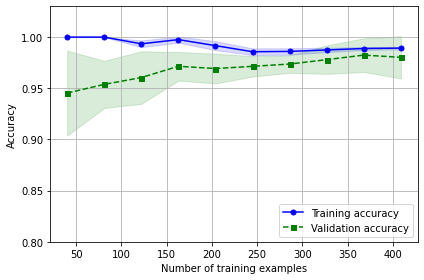

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', random_state=1, max_iter=10000))

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes = np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=1)


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15, color='green')



plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()


## 검증 곡선으로 과대적합과 과소적합 조사

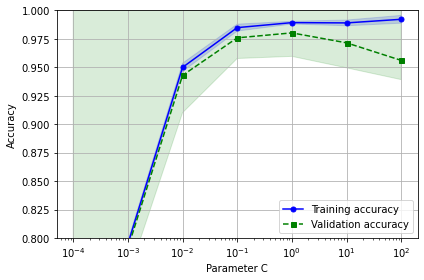

In [14]:
from sklearn.model_selection import validation_curve

param_range = [0.0001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    param_name = 'logisticregression__C',
    param_range=param_range,
    cv=10
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(param_range, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean+train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(param_range,
                 test_mean + test_mean,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

# 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝
## 그리드 서치를 사용한 하이퍼파라미터 튜닝

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C' : param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel':['rbf']}]

gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring='accuracy',
                  refit=True,
                  cv=10,
                  n_jobs=1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [16]:
clf = gs.best_estimator_

print('테스트 정확도: %.3f' % clf.score(X_test, y_test))

테스트 정확도: 0.974


In [17]:
gs=GridSearchCV(estimator=pipe_svc,
                param_grid=param_grid,
                scoring='accuracy',
                cv=10,
                return_train_score=True,
                n_jobs=-1)

gs = gs.fit(X_train, y_train)

In [19]:
gs.cv_results_['split0_train_score']

array([0.6405868 , 0.93643032, 0.97555012, 0.98777506, 0.98533007,
       0.99266504, 0.99755501, 1.        , 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.7799511 , 0.94621027,
       0.96577017, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.78484108, 0.94621027, 0.9804401 , 0.99266504, 1.        ,
       1.        , 1.        , 1.        , 0.94621027, 0.97799511,
       0.99266504, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.97799511, 0.98777506, 0.99511002, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.98533007,
       0.99266504, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

In [18]:
gs.cv_results_['mean_train_score']

array([0.6402928 , 0.93724074, 0.97240801, 0.98510406, 0.98803447,
       0.99145447, 0.99707019, 0.9992677 , 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.77070249, 0.94700817,
       0.97167094, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.77949371, 0.94725326, 0.97704753, 0.99291848, 1.        ,
       1.        , 1.        , 1.        , 0.94652096, 0.97753354,
       0.99023257, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.97680064, 0.98852287, 0.99755799, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.98803387,
       0.99291848, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

In [20]:
gs.cv_results_['split0_test_score']

array([0.63043478, 0.89130435, 0.95652174, 0.97826087, 0.95652174,
       0.93478261, 0.95652174, 0.93478261, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.69565217, 0.93478261,
       0.95652174, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.69565217, 0.93478261, 0.93478261, 1.        , 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.93478261, 0.97826087,
       1.        , 1.        , 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.97826087, 0.97826087, 0.97826087, 1.        ,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.97826087,
       0.95652174, 0.95652174, 1.        , 0.63043478, 0.63043478,
       0.63043478, 0.63043478])

In [21]:
print('테스트 정확도: %3f' %gs.score(X_test, y_test))

테스트 정확도: 0.973684


In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

distribution = loguniform(0.0001, 1000.0)

param_dist = [{'svc__C' : distribution,
              'svc__kernel': ['linear']},
              {'svc__C': distribution,
               'svc__gamma': distribution,
               'svc__kernel': ['rbf']}]

rs = RandomizedSearchCV(estimator = pipe_svc,
                        param_distributions=param_dist,
                        n_iter=30,
                        cv=10,
                        random_state=1,
                        n_jobs=-1)

rs= rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)


0.9824637681159419
{'svc__C': 210.6644070836221, 'svc__gamma': 0.0006861724481510375, 'svc__kernel': 'rbf'}
